___

# Atividade - Regressão Linear Simples - Gabarito

## Aula 24

___

<div id="indice"></div>

## Índice

- [Renda vs CO2](#base)
    - [Dados: Inner Join](#join)
    - [Problema](#problema)
- [Ajustando um modelo de regressão simples via Mínimos Quadrados](#regressao)
    - [Suposições do modelo](#suposicoes)
    - [Exercício 1 - $\hat{\beta}_1$ e  $\hat{\beta}_0$](#ex1)
    - [Verificando os resultados da regressão](#verificando-resultados)
    - [Exercício 2 - Resíduos ](#ex2)
- [Ajustando um modelo de regressão simples via `statsmodels.OLS`](#ols)
    - [Teste de hipóteses para os coeficientes](#th-coefs)
    - [Usando `statsmodels.OLS`](#usando-ols)
    - [Exercício 3 - Plot da reta ajustada](#ex3)
    - [Exercício 4 - Resíduos](#ex4)
    - [Exercício 5](#ex5)
- [Explicação sobre resultados e suposições do modelo de regressão linear:](#explica)
    - [Teste t :  valor-*p*  da estatística t](#testet)
    - [Coeficiente de determinação $R^2$](#r2)
    - [$R^2$ ajustado](#r2adj)
    - [Estatística F](#f)
    - [Teste Omnibus](#omnibus)
    - [Teste Jarque-Bera](#jb)
    - [Teste Durbin-Watson](#dw)
- [Utilização dos resultados e validação das suposições do modelo:](#uso)    
    - [Exercício 6 - Análise dos valores p](#ex6)
    - [Exercício 7 - Análise da estatística F](#ex7)
    - [Exercício 8 - Análise do $R^2$](#ex8)
    - [Exercício 9 - Análise de normalidade do resíduo](#ex9)
    - [Exercício 10 - Análise de homocedasticidade](#ex10)
___

___

<div id="base"></div>

# Renda vs CO2

Vamos trabalhar com os seguintes dados coletados do site https://www.gapminder.org/:
1. Emissão de CO2 per capita
1. Renda per capita

As linhas representam os países e as colunas representam a emissão de CO2 ou renda per capita em cada ano. Estamos interessados em investigar a relação entre essas variáveis.

Como os arquivos estão separados, será preciso juntá-los cruzando o país.

In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#Leitura dos arquivos em Excel
co2 = pd.read_excel('indicator CDIAC carbon_dioxide_emissions_per_capita.xlsx')
income = pd.read_excel('indicator gapminder gdp_per_capita_ppp.xlsx')

In [3]:
#É possível verificar que cada linha representa um país e as colunas representam o ano
co2.head(3)

,CO2 per capita,1751,1755,1762,1763,1764,1765,1766,1767,1768,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022704,0.027472,0.03678,0.04709,0.068312,0.131602,0.213325,0.262174,NaN,NaN
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#O mesmo se aplica a renda.
income.head(3)

,GDP per capita,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,...,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0,1884.0,1877.0,1925.0
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


___

<div id="join"></div>

### Dados: Inner Join

Vamos agora juntar as duas tabelas via país, selecionar apenas o ano de 2010 e remover os NaNs.

Ao final vamos fazer o gráfico de dispersão das duas variáveis.

**Sugestão**: pesquise sobre a função DataFrame.join(), pode ser muito útil no futuro.

In [5]:
#Cruza as duas tabelas via país
co2_index = co2.set_index('CO2 per capita')
income_index = income.set_index('GDP per capita')

df = co2_index.join(income_index, how='inner', lsuffix='_co2', rsuffix='_income')

In [6]:
#Seleciona o ano de 2010 e remove os NaNs
df = df[['2010_co2','2010_income']].dropna()
df.head()

,2010_co2,2010_income
Afghanistan,0.262174,1637.0
Albania,1.336544,9374.0
Algeria,3.480977,12494.0
Andorra,6.092100,38982.0
Angola,1.593918,7047.0


In [7]:
#Transforma a renda na escala de milhares de dólares
df['2010_income'] /= 1000
df.head()

,2010_co2,2010_income
Afghanistan,0.262174,1.637
Albania,1.336544,9.374
Algeria,3.480977,12.494
Andorra,6.092100,38.982
Angola,1.593918,7.047


___

<div id="problema"></div>

### Problema

Considere que o objetivo aqui seja **explicar/prever** a emissão de gás carbono (CO2) per capita de um país em função da renda (PIB) per capita.

Por conta disso, vamos considerar `CO2` como variável dependente (ou variável resposta ou variável *target*) para ser considerada no `eixo y` e `renda` como independente (ou explicativa ou *features*) no `eixo x`.

Proponha um gráfico para visualizar a relação entre essas variáveis.

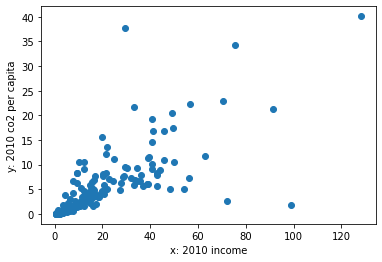

In [8]:
# PROF
x_dados = df['2010_income'] # Definindo renda como explicativa
y_dados = df['2010_co2']    # Definindo CO2 como resposta

plt.scatter(x_dados,y_dados);
plt.xlabel("x: 2010 income");
plt.ylabel("y: 2010 co2 per capita");

___

<div id="regressao"></div>

# Ajustando um modelo de regressão simples via Mínimos Quadrados

Vamos tentar agora ajustar um modelo sobre os dados. A primeira tentativa será ajustar um reta:

$$y_i=\beta_0+\beta_1x_i+\varepsilon_i$$

Onde:
1. $\beta_i$ são os coeficientes do modelo de regressão;
1. $\varepsilon_i$ representa os **erros aleatórios**. O erro aleatório tem média zero e variância (desconhecida) $\sigma^2$. Além disso, esses erros aleatórios correspondentes as diferentes observações são também considerados variáveis aleatórias não correlacionadas. Vide Montegomery e Runger (2018), Seção 11-2, página 335.

O primeiro passo agora é calcular os valores da regressão. Existem diversas formas de estimar os $\beta$s, vamos utilizar o método de **Mínimos Quadrados Ordinários (MQO ou OLS - Ordinary Least Squares em inglês)**. 

$$\hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x}$$

$$\hat{\beta}_1=\frac{S_{XY}}{S_{XX}}=\frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}$$

<div id="suposicoes"></div>

### Suposições do modelo

Para podermos aplicar o modelo é necessário fazermos algumas suposições:

1. Os **erros têm distribuição normal** com média 0 e variância constante, ou seja, $\varepsilon_i \sim N(0, \sigma^2)$.
2. Os **erros são independentes** entre si, ou seja, $Corr(\varepsilon_i, \varepsilon_j)=0$, para qualquer $i \neq j$.
3. **O modelo é linear nos parâmetros**.
4. **Homocedasticidade: $Var(\varepsilon_i) = \sigma^2$** para qualquer $i = 1, \dots, n$.

___

<div id="ex1"></div>

### EXERCÍCIO 1 - $\hat{\beta}_1$ e  $\hat{\beta}_0$

Calcule os valores de $\bar{x}$ e $\bar{y}$. Calcule também $S_{XX}$ e $S_{XY}$, em seguida calcule o $\hat{\beta}_1$ e o $\hat{\beta}_0$. Armazene os resultados de $\hat{\beta}_1$ e $\hat{\beta}_0$ nas variáveis `b1` e `b0`, respectivamente.

In [9]:
# ESCREVA SEU CÓDIGO AQUI

In [10]:
# PROF
#beta^0 e beta^1

x_dados = df['2010_income']
y_dados = df['2010_co2']

ybarra = y_dados.mean()
xbarra = x_dados.mean()

Sxy = ((x_dados -xbarra)*(y_dados -ybarra)).sum()
Sxx = ((x_dados -xbarra)**2).sum()

b1 = Sxy/Sxx
b0 = ybarra - b1*xbarra

print("Estimativa de beta0 (coeficente linear): {0}".format(b0))
print("Estimativa de beta1 (coeficente angular): {0}".format(b1))


Estimativa de beta0 (coeficente linear): 0.6557309117836843
Estimativa de beta1 (coeficente angular): 0.24326849086184094


In [11]:
x_dados.cov(y_dados)/x_dados.var()

0.24326849086184102

<div id="verificando-resultados"></div>

### Verificando os resultados da regressão

Vamos contrastar a reta estimada pelo modelo de regressão com os dados observados.

Para tanto, serão construídos:
 * `x_vec`: vetor de valores considerando a amplitude dos dados que estão no `eixo x`
 * `y_vec`: vetor com valores ajustados para y a partir de um valor de `x_vec`, considerando os coeficentes da reta

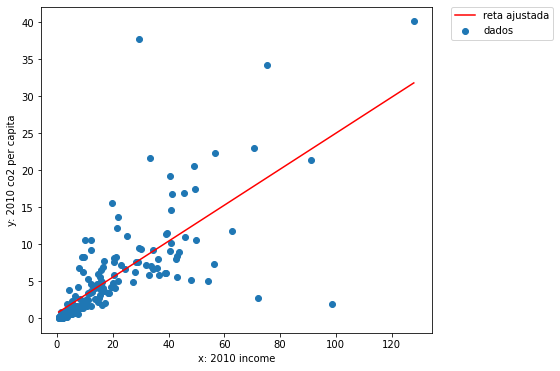

In [12]:
x_vec = np.linspace(x_dados.min(), x_dados.max(), 500)
y_vec = b0 + b1*x_vec

plt.figure(figsize=(7,6))
plt.plot(x_vec,y_vec, color="r") # resultados da regressão
plt.scatter(x_dados, y_dados); # dados
plt.xlabel("x: 2010 income")
plt.ylabel("y: 2010 co2 per capita")
plt.legend(('reta ajustada','dados'), bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

___

<div id="ex2"></div>

### EXERCÍCIO 2 - Resíduos 

Agora calcular o vetor de resíduos, dado por:
$$e_i=y_i-\hat{y_i}=y_i-(\hat{\beta}_0+\hat{\beta}_1x_i)$$

Ou seja, resíduo indica o que cada valor observado em $y$ ficou distante do valor previsto pela reta $\hat{y}$.

**Verifique GRAFICAMENTE a normalidade dos resíduos. Parece uma Normal?**

In [13]:
# ESCREVA SEU CÓDIGO AQUI

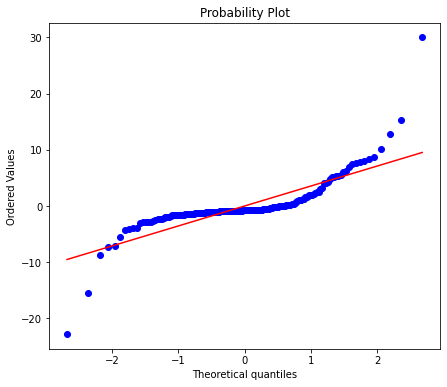

In [14]:
# PROF
residuos = y_dados - (b0 + b1*x_dados) # Escreva sua fórmula dos resíduos aqui 

plt.figure(figsize=(7,6))
stats.probplot(residuos, dist='norm', plot=plt); # Verifique graficamente se é uma normal - como fazer isso?

___

<div id="ols"></div>

# Ajustando um modelo de regressão simples via `statsmodels.OLS`

<div id="th-coefs"></div>

### Teste de hipóteses para os coeficientes 

Agora que já aprendemos Teste de Hipóteses, podemos verificar a significância dos $\beta$'s e para tal vamos testar:

$$H_0: \beta_i=0$$
$$H_1: \beta_i\neq0$$

com $i=0$ e $i=1$. A **significância da regressão** está na rejeição de $H_0: \beta_1=0$, pois isso torna a variável descrita em $x$ relevante ao modelo para melhor prever a variável descrita em $y$.


Verifique os resultados da regressão obtidos considerando o comando `OLS` contido no pacote `statsmodelos.api`.

Considerando os resultados desse ajuste obtido pelo `summary`, responda os exercícios.

___

<div id="usando-ols"></div>

### Usando `statsmodels.OLS`

Agora que estão familiarizados com algumas medidas obtidas na "unha" calculando $\hat{beta}_0$ e $\hat{beta}_1$ com as expressões obtidas pelo método dos mínimos quadrados, vamos aprender como utilizar a função `OLS()` da biblioteca `statsmodel` e interpretar os resultados.

In [15]:
import statsmodels.api as sm # Importe da biblioteca

In [16]:
# Repetindo - mas já fizemos isso anteriormente
x_dados = df['2010_income'] # Definindo renda como explicativa
y_dados = df['2010_co2']    # Definindo CO2 como resposta

# Matriz de 1s e valores de x_dados
X_dados = sm.add_constant(x_dados) # Adiciona coluna de 1s para estimar intercepto junto com a coluna de x (dados)

In [17]:
# Define o modelo
model = sm.OLS(y_dados, X_dados)    

# Faz o ajuste
results = model.fit()   

# Mostra os resultados
results.summary()       

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               2010_co2   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     235.2
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           9.80e-35
Time:                        17:47:47   Log-Likelihood:                -534.72
No. Observations:                 186   AIC:                             1073.
Df Residuals:                     184   BIC:                             1080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6557      0.423      1.551      0.123      -0.178       1.490
2010_income     0.2433      0.016     15.337      0.000       0.212       0.275
==============================================================================
Omnibus:                      100.299   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2384.399
Skew:                           1.435   Prob(JB):                         0.00
Kurtosis:                      20.304   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**AGORA USE A SAIDA do OLS Regression Results**

Como resultado do `statsmodels.OLS` obtivemos a tabela acima, que contém diversas informações e pode ser um pouco intimidadora em um primeiro contato. Inicialmente estamos interessados apenas nos valores de $\hat\beta_0$ (intercepto: `const`) e $\hat\beta_1$ (inclinação da reta: `2010_income`). Esses valores podem ser encontrados na coluna `coef` do *output* do OLS Regression Results. Posteriormente vamos entender algumas das outras informações disponíveis nesse resultado.

In [18]:
beta0 = results.params['const']
beta1 = results.params['2010_income']

print("Estimativa de beta0 (coeficente linear): {0}".format(beta0))
print("Estimativa de beta1 (coeficente angular): {0}".format(beta1))

Estimativa de beta0 (coeficente linear): 0.6557309117836843
Estimativa de beta1 (coeficente angular): 0.24326849086184088


___

<div id="ex3"></div>

### EXERCÍCIO 3 - Plot da reta ajustada

Usando os resultados da equação obtida via `statsmodels`, plote novamente a reta ajustada sobre os pontos. 

**Dica 1**: você pode utilizar o `results.predict` (consulte a documentação).

**Dica 2**: para usar essa função você pode precisar do `sm.add_constant` (utilizado [aqui](usando-ols)).

In [19]:
# ESCREVA SEU CÓDIGO AQUI

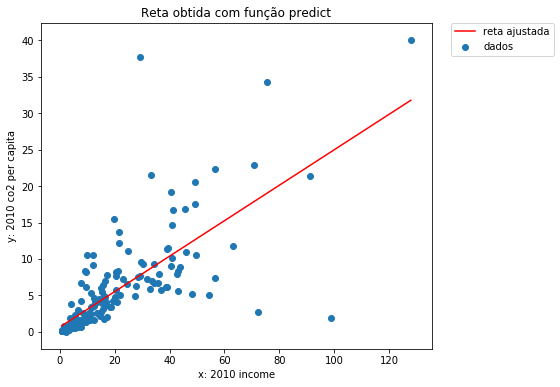

In [20]:
# PROF

x_vec = np.linspace(x_dados.min(), x_dados.max(), 500)
X_vec = sm.add_constant(x_vec) # Matriz com 1a e coluna de vetor de valores de acordo com amplitude de x_dados
y_vec = results.predict(X_vec)

plt.figure(figsize=(7,6))
plt.plot(x_vec, y_vec, color="r") # resultados da regressão
plt.scatter(x_dados, y_dados); # dados
plt.title("Reta obtida com função predict")
plt.xlabel("x: 2010 income")
plt.ylabel("y: 2010 co2 per capita")
plt.legend(('reta ajustada','dados'), bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

<div id="ex4"></div>

### EXERCÍCIO 4 - Resíduos

Gere o `probplot` dos resíduos para verificar a sua normalidade.

**Dica**: Você pode obter o valor dos resíduos no atributo `resid` dos resultados da regressão (`results.resid`).

In [21]:
# ESCREVA SEU CÓDIGO AQUI

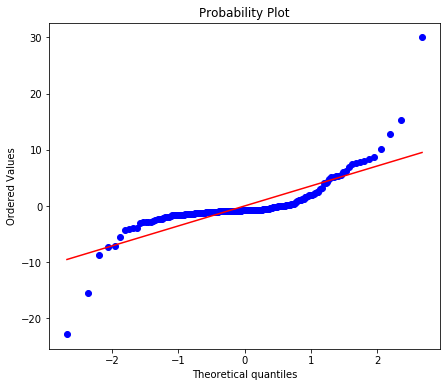

In [22]:
# PROF
plt.figure(figsize=(7,6))
stats.probplot(results.resid, dist="norm", plot=plt);

___

<div id="ex5"></div>

### EXERCÍCIO 5 

Interprete os resultados acima. Você acha que os resíduos formam uma normal? Discuta a homocedasticidade do modelo (a variância dos erros é constante?).

In [23]:
# ESCREVA SUA RESPOSTA AQUI

In [24]:
# PROF
print('''

**R.: **

De acordo com o formato dos dados (pontos azuis) em relação a linha reta (vermelha) no plot de normalidade dos resíduos (gráfico construído na Tarefa 3), temos indicativos de caudas mais leves nos dados do que as caudas da distribuição normal. Vide Montgmory e Runger (2018), Seção 6-6, página 185, para mais detalhes.

Para validar, descritivamente, a suposição de homocedasticidade, pode-se utilizar o plot da reta ajustada sobre os pontos (primeiro gráfico apresentado na Tarefa 3). Esse gráfico mostra que a variabilidade da variável **y: 2010 co2 per capita** em torno da reta ajustada aumenta conforme aumenta os valores da variável **x: 2010 income** e essa disposição dos pontos pode ser um indicativo de que a suposição de homocedasticidade não seja válida nesse ajuste. 
''')



**R.: **

De acordo com o formato dos dados (pontos azuis) em relação a linha reta (vermelha) no plot de normalidade dos resíduos (gráfico construído na Tarefa 3), temos indicativos de caudas mais leves nos dados do que as caudas da distribuição normal. Vide Montgmory e Runger (2018), Seção 6-6, página 185, para mais detalhes.

Para validar, descritivamente, a suposição de homocedasticidade, pode-se utilizar o plot da reta ajustada sobre os pontos (primeiro gráfico apresentado na Tarefa 3). Esse gráfico mostra que a variabilidade da variável **y: 2010 co2 per capita** em torno da reta ajustada aumenta conforme aumenta os valores da variável **x: 2010 income** e essa disposição dos pontos pode ser um indicativo de que a suposição de homocedasticidade não seja válida nesse ajuste. 



___

<div id="explica"></div>

# Explicação sobre resultados e suposições do modelo de regressão linear:

Os resumo dos resultados da regressão traz informações que nos permitem avaliar a qualidade do ajuste e a validade de:

* Validação das suposições (normalidade, homocedasticidade e independência dos resíduos)
* Teste de hipóteses dos coeficientes do modelo de regressão 

<div id="testet"></div>

### Teste t :  valor-*p*  da estatística t

Existente para cada coeficiente $\beta_i$ do modelo de regressão, testam as seguintes hipóteses:

$H_0: \beta_i = 0$

$H_1: \beta_i \neq 0$

Um valor-*p* (encontrado na coluna `P>|t|`) baixo permite **rejeitar** a hipótese $H_0: \beta_i = 0$. No caso de um modelo de regressão simples, as hipóteses para o coeficiente $\beta_1$ dizem sobre a significância da regressão.

In [25]:
valorp_beta0 = results.pvalues['const']
valorp_beta1 = results.pvalues['2010_income']

print('Valor-p sob H0: beta0 = 0: {:.6f}'.format(valorp_beta0))
print('Valor-p sob H0: beta1 = 0: {:.6f}'.format(valorp_beta1))

Valor-p sob H0: beta0 = 0: 0.122661
Valor-p sob H0: beta1 = 0: 0.000000


<div id="r2"></div>

### Coeficiente de determinação $R^2$

É uma medida de quão bem uma regressão capta a variação presente nos dados, ou parafraseando, o quanto de variabilidade nos dados é explicada pelo modelo de regressão.

$$ R^2 = 1 - \frac{SS_E}{SS_T}$$

Para calcular esta fórmula precisamos das relações:

$$SQRes=SS_{E}=\sum\limits^{n}_{i=1}(y_i-\hat{y}_i)^2=\sum\limits_{i=1}^{n}\epsilon^2_{i}$$

$$SQT=SS_{T}=\sum\limits^{n}_{i=1}(y_i-\bar{y})^2$$

O valor de $R^2$ pode ser obtido na coluna `R-squared`.

<div id="r2adj"></div>

### $R^2$ ajustado

Penaliza preditores que não acrescentam poder preditivo significativo. Essa medida é útil em modelo de regressão múltipla.

$$R^2ajustado = R^2 - (1-R^2)\frac{P}{n-p-1}$$

em que $n$ é o número de dados e $p$ é o número de preditores (número de variáveis explicativas)

O valor de $R^2$ ajustado pode ser obtido na coluna `Adj. R-squared`.


<div id="f"></div>

### Estatística F

Testa as seguintes hipóteses:

$H_0: \beta_1 = \beta_2 = \ldots = \beta_p = 0$

$H_1: \beta_i \neq 0$ para no mínimo algum $i$, com $i=1,\ldots,n$ 

A rejeição da hipótese nula implica que no mínimo uma variável explicativa (regressora) contruibui significantemente para o modelo. Esse teste F é mais útil no caso de modelo de regressão múltipla.

O valor p dessa estatística pode ser obtido na coluna `Prob (F-statistic)`. Se ele for menor do que o nível de significância escolhido, rejeitamos $H_0$ em favor de $H_1$ (alguma variável explicativa contribui significativamente para o modelo).


<div id="omnibus"></div>

### Teste Omnibus

Para que o modelo obtido via regressão linear simples possa ser considerado para tomada de decisão é necessário que as [suposições do modelo](#suposicoes) sejam válidas. O teste Omnibus testa a normalidade dos resíduos ($\varepsilon_i$):

$H_0:$ a distribuição dos resíduos é normal

$H_1:$ a distribuição dos resíduos não é normal

O valor-p desse teste pode ser obtido em `Prob(Omnibus)`. Se `Prob(Omnibus)` for muito baixo, existe evidência de que os resíduos **não são** distribuídos normalmente, violando nesse caso a suposição do modelo de regressão. O **ideal** é que esse valor seja maior do que $\alpha$ (nível de significância), assim não rejeitamos $H_0$.


<div id="jb"></div>

### Teste Jarque-Bera

Outro teste de normalidade dos resíduos:

$H_0:$ a distribuição dos resíduos é normal

$H_1:$ a distribuição dos resíduos não é normal

O valor-p desse teste pode ser obtido em `Prob(JB)`. Se `Prob(JB)` for muito baixo, existe evidência de que os resíduos **não são** distribuídos normalmente, violando nesse caso a suposição do modelo de regressão. O **ideal** é que esse valor seja maior do que $\alpha$ (nível de significância), assim não rejeitamos $H_0$.

Consulte este [link](https://towardsdatascience.com/testing-for-normality-using-skewness-and-kurtosis-afd61be860) para mais detalhes sobre qual o propósito do teste JB para validar normalidade de dados.



<div id="dw"></div>

### Teste Durbin-Watson

Testa a autocorrelação dos resíduos. Uma das [suposições](#suposicoes) é que os resíduos são independentes entre si. Esse valor varia na faixa $[0,4]$:

* Um valor próximo de $2$ sugere que não há autocorrelação dos resíduos
* Um valor menor que $2$ sugere **correlação positiva** dois resíduos
* Um valor maior que $2$ sugere **correlação negativa** dois resíduos

O **ideal** é que o valor de `Durbin-Watson` seja próximo de 2.

___
<div id="uso"></div>

# Utilização dos resultados e validação das suposições do modelo:

<div id="ex6"></div>

### EXERCÍCIO 6 - Análise dos valores p

O que os valores-p da regressão dizem a respeito dos *betas?*

In [26]:
# ESCREVA SUA RESPOSTA AQUI

In [27]:
# PROF

print('''

**R.:**

A coluna **P>|t|** obtida do comando `results.summary()` indica o resultado do valor *p* de cada coeficiente do modelo de regressão. No caso, seu resultado mostra se a variável regressora é relevante para explicar a variável dependente quando o valor *p* é baixo. 

Considerando a saida acima, há suficiente evidência de que a variável **2010_income** é relevante ao modelo, ou seja, há evidência de que $\beta_1$ é diferente de zero dando significância ao modelo de regressão.

''')



**R.:**

A coluna **P>|t|** obtida do comando `results.summary()` indica o resultado do valor *p* de cada coeficiente do modelo de regressão. No caso, seu resultado mostra se a variável regressora é relevante para explicar a variável dependente quando o valor *p* é baixo. 

Considerando a saida acima, há suficiente evidência de que a variável **2010_income** é relevante ao modelo, ou seja, há evidência de que $eta_1$ é diferente de zero dando significância ao modelo de regressão.




___

<div id="ex7"></div>

### EXERCÍCIO 7 - Análise da estatística F

O que o valor da estatística F diz sobre a qualidade da regressão? 

Diga qual hipótese nula e alternativa $Prob(F)$ avalia.

In [28]:
# ESCREVA SUA RESPOSTA AQUI

In [29]:
# PROF

print('''

**R.:**

No caso da aplicação aqui feita ser de regressão simples (uma única variável explicativa), as hipóteses do teste F se resumem a:

$H_0: \beta_1 = 0$

$H_1: \beta_1 \neq 0$

ou seja, o teste F se reduz ao teste t no caso de um modelo de regressão simples.

Considerando o resultado de **Prob (F-statistic)** descrito na saida do `results.summary()`, temos evidência de rejeita a hipótese nula acima como era de se esperar pela conclusão obtida no teste t anterior.
''')



**R.:**

No caso da aplicação aqui feita ser de regressão simples (uma única variável explicativa), as hipóteses do teste F se resumem a:

$H_0: eta_1 = 0$

$H_1: eta_1 
eq 0$

ou seja, o teste F se reduz ao teste t no caso de um modelo de regressão simples.

Considerando o resultado de **Prob (F-statistic)** descrito na saida do `results.summary()`, temos evidência de rejeita a hipótese nula acima como era de se esperar pela conclusão obtida no teste t anterior.



___

<div id="ex8"></div>

### EXERCÍCIO 8 - Análise do $R^2$

O que o valor de $R^2$ obtido diz sobre o poder explicativo da regressão obtida via OLS?

In [30]:
# ESCREVA SUA RESPOSTA AQUI

In [31]:
# PROF
print('''

**R.:**

Considerando o resultado de **R-squared** descrito na saida do `results.summary()`, temos que o modelo explica $56,1\%$ da variabilidade dos dados. Entretanto é importante ter cuidado ao interpretar essa medida ainda mais no caso que notamos, descritivamente, a possível não adequação da suposição de homocedasticidade. Isso pode, por exemplo, fornecer previsões não necessariamente exatas de futuras previsões.
''')



**R.:**

Considerando o resultado de **R-squared** descrito na saida do `results.summary()`, temos que o modelo explica $56,1\%$ da variabilidade dos dados. Entretanto é importante ter cuidado ao interpretar essa medida ainda mais no caso que notamos, descritivamente, a possível não adequação da suposição de homocedasticidade. Isso pode, por exemplo, fornecer previsões não necessariamente exatas de futuras previsões.



___

<div id="ex9"></div>

### EXERCÍCIO 9 - Análise de normalidade do resíduo

O que os testes *Omnibus* e *Jarque-Bera* dizem a respeito da normalidade do resíduo? 

In [32]:
# ESCREVA SUA RESPOSTA AQUI

In [33]:
# PROF
print('''
**R.:**

Tanto pelo resultado de **Prob(Omnibus)** como do **Prob(JB)** mostram valores *p* extremamente pequenos, menores do que $<0,001$. Nesse caso, pode-se concluir que não há evidências de normalidade dos resíduos.
''')


**R.:**

Tanto pelo resultado de **Prob(Omnibus)** como do **Prob(JB)** mostram valores *p* extremamente pequenos, menores do que $<0,001$. Nesse caso, pode-se concluir que não há evidências de normalidade dos resíduos.



___

<div id="ex10"></div>

### EXERCÍCIO 10 - Análise de homocedasticidade

Verifique visualmente se a hipótese de homocedasticidade é válida.

In [34]:
# ESCREVA SUA RESPOSTA AQUI

In [35]:
# PROF
print('''
**R.: **

Para validar, descritivamente, indicativos na suposição de homocedasticidade considerando os resíduos obtidos do modelo ajustado, pode ser feito gráficos dos resíduos $e_i=y_i-\hat{y}_i$ contra os valores preditos $\hat{y}_i$ e contra cada variável independente $x_i$, com $i=1,\ldots,n$. Vide Montgomery e Runger (2018), Seção 11-7.1, página 351, para mais detalhes.

Interprentando os gráficos abaixo, nota-se que a variância dos resíduos está crescendo com a magnitiude de $y_i$ e com a magnitude de $x_i$ dando indicativo que a suposição de homocedasticidade deva estar violada. Uma solução pode ser a transformação nas variáveis dependente e/ou independentes ou usar modelos de regressão mais robustos. 
''')


**R.: **

Para validar, descritivamente, indicativos na suposição de homocedasticidade considerando os resíduos obtidos do modelo ajustado, pode ser feito gráficos dos resíduos $e_i=y_i-\hat{y}_i$ contra os valores preditos $\hat{y}_i$ e contra cada variável independente $x_i$, com $i=1,\ldots,n$. Vide Montgomery e Runger (2018), Seção 11-7.1, página 351, para mais detalhes.

Interprentando os gráficos abaixo, nota-se que a variância dos resíduos está crescendo com a magnitiude de $y_i$ e com a magnitude de $x_i$ dando indicativo que a suposição de homocedasticidade deva estar violada. Uma solução pode ser a transformação nas variáveis dependente e/ou independentes ou usar modelos de regressão mais robustos. 



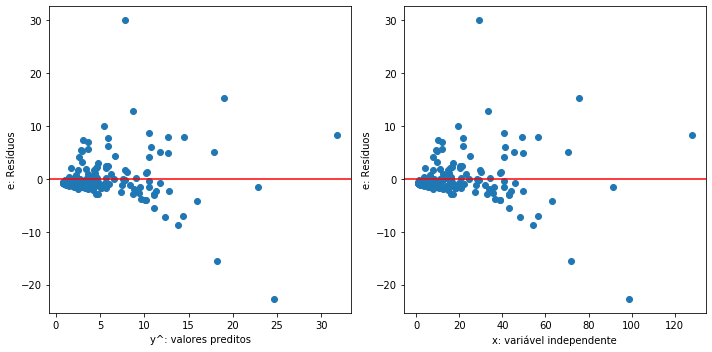

In [36]:
# PROF
# Calcula os valores preditos a partir da matriz de 1s e de x_dados
y_predito = results.predict(X_dados)

fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(y_predito, results.resid); #X_dados contem matriz de planejamento usada no ajuste OLS 
plt.axhline(y=0, color='r', linestyle='-');
plt.ylabel('e: Resíduos')
plt.xlabel('y^: valores preditos')

plt.subplot(122)
plt.scatter(x_dados, results.resid); #x_dados contem apenas a variável independente utilizada no ajuste linear
plt.axhline(y=0, color='r', linestyle='-');
plt.ylabel('e: Resíduos')
plt.xlabel('x: variável independente')

plt.tight_layout()
plt.show()